[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/4.3.classifier_train.ipynb)

# Система распознавания дорожных знаков на датасете RTSD
## Обучение классификатора
Клиссификатор классифицирует дорожные знаки, которые обнаружил детектор

In [1]:
colab = False

if colab == True:
    #!pip install fiftyone
    !pip install kaggle

    from google.colab import drive
    drive.mount('/content/drive')
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    
    !mkdir data

    !kaggle datasets download watchman/rtsd-dataset
    !mkdir data/RTSD
    !unzip -q rtsd-dataset.zip -d ./data/RTSD/
    !rm rtsd-dataset.zip
    !cp -r data/RTSD/rtsd-frames/rtsd-frames/ data/RTSD
    !rm -r data/RTSD/rtsd-frames/rtsd-frames/
    
    !kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
    !mkdir data/GTSRB
    !unzip -q gtsrb-german-traffic-sign.zip -d ./data/GTSRB/
    !rm gtsrb-german-traffic-sign.zip

    !kaggle datasets download mahadevkonar/belgiumts-dataset
    !mkdir data/BelgiumTS
    !unzip -q belgiumts-dataset.zip -d .data/BelgiumTS/
    !rm belgiumts-dataset.zip

    !kaggle datasets download dmitryyemelyanov/chinese-traffic-signs
    !mkdir data/ChineseTS
    !unzip -q chinese-traffic-signs.zip -d ./data/ChineseTS/
    !rm chinese-traffic-signs.zip

In [70]:
import json
import os
import time
import random
import numpy as np
import pandas as pd 

#import cv2
from PIL import Image
#import matplotlib
#matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
#import matplotlib.patches as patches
%matplotlib inline
from IPython.display import clear_output

#from pycocotools.coco import COCO

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
#from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
#from torchvision import models
import torchvision.transforms as transforms
from torchvision.models import resnet50, resnet152

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from sklearn import metrics

### Пути и параметры

In [3]:
checkpoints_path = 'checkpoints' if colab == False else '../content/drive/MyDrive/TSR/checkpoints'
saved_data_path  = 'data' if colab == False else '../content/drive/MyDrive/TSR/data'

bg_samples_val = 300        # количество экземпляров класса background на валидации
batch_size = 32
num_classes = 156

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name(0) if device.type == 'cuda' else device.type)

NVIDIA GeForce RTX 3090


### Загрузчик данных

In [4]:
'''# Удаление категорий с количеством знаков меньше порога
sign_threshold = 10
filt = lambda x: x.sign.count() > sign_threshold
RTSD_train_exp_lim = RTSD_train_exp.groupby('category_id').filter(filt)

print("Количество уникальных категорий: {}".format(len(RTSD_train_exp.category_id.unique())))
RTSD_train_exp_lim''';

In [5]:
class dataset_for_classifier(Dataset):
    '''
    Класс объединяет объекты датасетов с аннотацией в формате COCO в один датасет
    При обращении к объекту он кадрируется по ограничивающей рамке
   
    параметры:
    images_anno_paths - список кортежей или списков с путями к изображениям и путями к аннотациям
    transforms        - набор преобразований изображения (аугментации, преобразование в тензор)
    samples_in_class  - при задании значения берется заданное количество экземплров класса
    bbox_expand_perc  - процент, на который увеличивается ограничивающая рамка знака
    bbox_expand_pixel - минимальное количество пикселей, на которое увеличивается ограничивающая рамка знака
    '''
    def __init__(self, images_anno_paths, transforms, samples_in_class=None,
                 bbox_expand_perc=None, bbox_expand_pixel=None):
        super().__init__()
        
        self.anno = self.make_anno_list(images_anno_paths)
        #self.anno = self.make_anno_df(images_anno_paths)
        
        # балансировка классов равным количество сэмплов
        if samples_in_class is not None:
            self.data_sampling(samples_in_class)

        self.transforms = transforms
        self.bbox_expand_perc = bbox_expand_perc/100 if bbox_expand_perc is not None else 0
        self.bbox_expand_pixel = bbox_expand_pixel if bbox_expand_pixel is not None else 0

    def __len__(self):      
        return len(self.anno)

    def __getitem__(self, index):
        
        if type(self.anno).__name__ == 'list':
            img_name = self.anno[index]['file_name']
            bbox = self.anno[index]['bbox']
            if (self.bbox_expand_perc !=0) or (self.bbox_expand_pixel !=0):
                width = self.anno[index]['width']
                height = self.anno[index]['height']
                bbox = self.expand_bbox(bbox, width, height)
            label = torch.tensor(self.anno[index]['category_id'])
        else:
            img_name = self.anno.at[index,'file_name']
            bbox = self.anno.at[index,'bbox']
            if (self.bbox_expand_perc is not None) or (self.bbox_expand_pixel is not None):
                width = self.anno.at[index,'width']
                height = self.anno.at[index,'height']
                bbox = self.expand_bbox(bbox, width, height)
            label = torch.tensor(self.anno.at[index,'category_id'])

        # Загрузка изображения
        #img = cv2.imread(os.path.join(self.root, path))
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # загрузка с помощью PIL оказалась быстрее, чем с помощью OpenCV
        img = Image.open(img_name)
        img = img.crop(bbox)
        
        img = self.transform(img)

        return {'images':img, 'labels':label}
    
    def make_anno_list(self, images_anno_paths):

        new_anno = []
        id=0                            # новый ID аннотации (нумерация сквозная)
        
        # для каждого файла аннотации в списке аннотаций
        for images_path, anno_path in images_anno_paths:
            
            # загрузка аннотации
            with open(anno_path, 'r') as read_file:
                anno = json.load(read_file)

            # аннотации изображений для более быстрого поиска по ID
            images_anno = {item['id']:item for item in anno['images']}
            # аннотации категорий для более быстрого поиска по ID
            categories_anno = {item['id']:item for item in anno['categories']}
            
            for annotation in anno.get('annotations'):
                
                sample = {}
                sample['id'] = id
                
                image_id = annotation['image_id']
                anno_image = images_anno[image_id]
                sample['file_name'] = os.path.join(images_path, anno_image['file_name'])
                sample['width'] = anno_image['width']
                sample['height'] = anno_image['height']

                x1, y1, w, h = annotation['bbox']
                sample['bbox'] = [round(x1), round(y1), round(x1+w), round(y1+h)]

                category_id = annotation['category_id']
                sample['category_id'] = category_id
                if category_id==0:
                    sample['category_name'] = 'background'
                else:
                    sample['category_name'] = categories_anno[category_id]['name']
                
                new_anno.append(sample)
                id+=1
        
        return new_anno
    
    def make_anno_df(self, images_anno_paths):

        # для каждого файла аннотации в списке аннотаций
        for images_path, anno_path in images_anno_paths:
            
            # загрузка аннотации
            with open(anno_path, 'r') as read_file:
                anno = json.load(read_file)

            # Загрузка аннотаций в датафрейм
            df_anno = pd.DataFrame(anno.get('annotations')) 
            
            # преобразование столбца bbox из формата COCO (x1, y1, w, h) в формат (x1, y1, x2, y2) и округление
            df_anno['bbox'] = df_anno['bbox'].apply(lambda x: [round(x[0]), round(x[1]), round(x[0] + x[2]), round(x[1] + x[3])])

            # Добавление путей к файлам
            
            df_images = pd.DataFrame(anno.get('images'))
            df_images['file_name'] = df_images['file_name'].apply(lambda x: os.path.join(images_path, x))
            df_anno = df_anno.merge(df_images, left_on='image_id', right_on='id')
            
            # Добавление имен категорий (кодов знаков)
            df_category = pd.DataFrame(anno.get('categories'))
            df_anno = df_anno.merge(df_category, left_on='category_id', right_on='id')[['file_name','width','height',
                                                                                          'bbox','category_id','name']]
            df_anno.rename(columns={'name':'category_name'}, inplace=True)
            
            # конкатенируем полученный датасет с общим датасетом
            try:
                new_anno = pd.concat((new_anno, df_anno), ignore_index=True)    
            except:      # если общего датасета еще нет - присваиваем ему полученный датасет
                new_anno = df_anno

        return new_anno
    
    def data_sampling(self, samples_in_class):
        if type(self.anno).__name__ == 'list':
            new_anno = []
            id=0
            categories = list(set([item['category_id'] for item in self.anno]))
            for category_id in categories:
                category_samples = [x for x in self.anno if x['category_id'] == category_id]
                for i in range(samples_in_class):
                    sample = random.choice(category_samples)
                    sample['id'] = id
                    new_anno.append(sample)
                    id+=1
                    
            self.anno = new_anno

        else:
            self.anno = self.anno.groupby('category_id', group_keys= False).apply(lambda x: x.sample(samples_in_class, replace=True))
            self.anno.reset_index(inplace=True)
            del self.anno['index']

    def expand_bbox(self, bbox, width, height):
        sign_w = bbox[2] - bbox[0]          # ширина знака
        sign_h = bbox[3] - bbox[1]          # высота знака
        
        # новые границы шире на bbox_expand_perc процентов, но не менее, чем на bbox_expand_pixel пикселей
        x1 = max(bbox[0] - round(max((sign_w*self.bbox_expand_perc), self.bbox_expand_pixel)), 0)
        y1 = max(bbox[1] - round(max((sign_h*self.bbox_expand_perc), self.bbox_expand_pixel)), 0)
        x2 = min(bbox[2] + round(max((sign_w*self.bbox_expand_perc), self.bbox_expand_pixel)), width)
        y2 = min(bbox[3] + round(max((sign_h*self.bbox_expand_perc), self.bbox_expand_pixel)), height)
        new_bbox = [x1, y1, x2, y2]

        return new_bbox
    
    def transform(self, img):
        if self.transforms.__module__ == 'torchvision.transforms.transforms':
            img = self.transforms(img)
        else:
            img = (self.transforms(image=np.array(img))['image'])/255
        return img

In [6]:
def get_transform(augmentation_lib = 'torchvision', train=False):
    if augmentation_lib =='torchvision':
        if train == True:
            return transforms.Compose([transforms.Resize((224,224)),
                                       transforms.RandomChoice([transforms.Compose([transforms.RandomPerspective(distortion_scale=0.4,p=0.9),
                                                                                    transforms.ToTensor()
                                                                                    ]),
                                                                transforms.Compose([transforms.ColorJitter(brightness=(0.4), contrast=(0.3), saturation=(0.3)),
                                                                                    transforms.ToTensor()
                                                                                    ]),
                                                                transforms.Compose([transforms.RandomResizedCrop((224,224), scale=(0.85, 1)), # Случайная обрезка изображения в диапахоне 85 - 100% и resize в исходный размер
                                                                                    transforms.ToTensor()
                                                                                    ]),
                                                                transforms.Compose([transforms.ToTensor(),
                                                                                    transforms.RandomErasing(p = 0.4, scale = (0.003, 0.1)),
                                                                                    transforms.RandomErasing(p = 0.6, scale = (0.003, 0.05)),
                                                                                    transforms.RandomErasing(p = 0.6, scale = (0.003, 0.05)),
                                                                                    transforms.RandomErasing(p = 0.6, scale = (0.003, 0.02)),
                                                                                    transforms.RandomErasing(p = 0.6, scale = (0.003, 0.02)),
                                                                                    transforms.RandomErasing(p = 0.6, scale = (0.001, 0.01)),
                                                                                    transforms.RandomErasing(p = 0.6, scale = (0.001, 0.01)),
                                                                                    transforms.RandomErasing(p = 0.6, scale = (0.001, 0.01)),
                                                                                    transforms.RandomErasing(p = 0.6, scale = (0.001, 0.01)),
                                                                                    transforms.RandomErasing(p = 0.6, scale = (0.001, 0.01)),
                                                                                    ])        
                                                                ])
                                       ])
        else:
            return transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       #transforms.Normalize([0.485, 0.456, 0.406],
                                       #                     [0.229, 0.224, 0.225])
                                       ])   
    
    elif augmentation_lib =='albumentations':
        if train==True:
            return A.Compose([A.augmentations.geometric.resize.Resize (224, 224, interpolation=1, always_apply=False, p=1),
                              A.augmentations.transforms.GaussNoise (var_limit=(0.01, 0.05), mean=0, per_channel=False, always_apply=False, p=0.2),
                              A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
                              A.RandomFog(fog_coef_lower=0.2, fog_coef_upper=0.3, alpha_coef=0.1, p=0.05), #Туман
                              A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=5, p=0.05),
                              A.Rotate(limit=10, p=0.5),
                              ToTensorV2(p=1.0)
                              ])
            
        else:
            return A.Compose([A.augmentations.geometric.resize.Resize (224, 224, interpolation=1, always_apply=False, p=1),
                              ToTensorV2(p=1.0)
                              ])

In [7]:
def plot_sign(img, label=None):
    img = img.permute(1, 2, 0).detach().numpy()
    if label:
        print(f'Метка класса: {label}')
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(2,2)
    a.imshow(img);

Визуализация примера аугментации с помощью библиотеки torchvision

Метка класса: 1


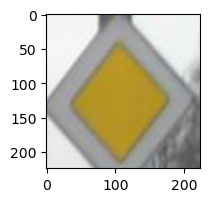

In [8]:
test = dataset_for_classifier([(os.path.join('data', 'RTSD'), os.path.join('data', 'RTSD', 'train_anno_reduced.json'))],
                                get_transform(augmentation_lib = 'torchvision', train=True))
sample = test.__getitem__(2)
plot_sign(sample['images'], sample['labels'])

Визуализация примера аугментации с помощью библиотеки torchvision

Метка класса: 1


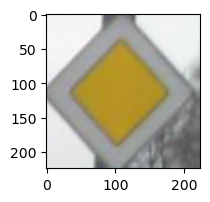

In [9]:
test = dataset_for_classifier([(os.path.join('data', 'RTSD'), os.path.join('data', 'RTSD', 'train_anno_reduced.json'))],
                                get_transform(augmentation_lib = 'albumentations', train=True))
sample = test.__getitem__(2)
plot_sign(sample['images'], sample['labels'])

In [10]:
train_dataset = dataset_for_classifier([(os.path.join('data', 'RTSD'), os.path.join(saved_data_path, 'train_anno_reduced_background.json')),
                                        (os.path.join('data', 'RTSD'), os.path.join('data', 'RTSD', 'train_anno.json')),
                                        (os.path.join('data', 'GTSRB'), os.path.join(saved_data_path, 'GTSRB_train_anno.json')),
                                        (os.path.join('data', 'GTSRB'), os.path.join(saved_data_path, 'GTSRB_test_anno.json')),
                                        (os.path.join('data', 'BelgiumTS'), os.path.join(saved_data_path, 'BelgiumTS_train_anno.json')),
                                        (os.path.join('data', 'BelgiumTS'), os.path.join(saved_data_path, 'BelgiumTS_test_anno.json')),
                                        (os.path.join('data', 'ChineseTS'), os.path.join(saved_data_path, 'ChineseTS_anno.json')),
                                        ],
                                        get_transform(augmentation_lib = 'torchvision', train=True))

# Ограничим количество экземпляров класса background для валидационной выборки
with open(os.path.join(saved_data_path, 'val_anno_background.json'), 'r') as read_file:
    RTSD_val_anno_background_short = json.load(read_file)
RTSD_val_anno_background_short['annotations'] = random.choices(RTSD_val_anno_background_short['annotations'], k=bg_samples_val)
with open(os.path.join(saved_data_path, 'val_anno_background_short.json'), 'w') as f:
    json.dump(RTSD_val_anno_background_short, f)#, cls=NpEncoder)

val_dataset = dataset_for_classifier([(os.path.join('data', 'RTSD'), os.path.join(saved_data_path, 'val_anno_background_short.json')),
                                      (os.path.join('data', 'RTSD'), os.path.join('data', 'RTSD', 'val_anno.json'))
                                      ],
                                      get_transform(augmentation_lib = 'torchvision', train=False))

In [78]:
# для эксперимента


train_dataset = dataset_for_classifier([#(os.path.join('data', 'RTSD'), os.path.join(saved_data_path, 'train_anno_reduced_background.json')),
                                        (os.path.join('data', 'RTSD'), os.path.join('data', 'RTSD', 'train_anno_reduced.json'))],
                                        get_transform(augmentation_lib = 'torchvision', train=True))

val_dataset = dataset_for_classifier([#(os.path.join('data', 'RTSD'), os.path.join(saved_data_path, 'val_anno_background_short.json')),
                                      (os.path.join('data', 'RTSD'), os.path.join('data', 'RTSD', 'val_anno.json'))
                                      ],
                                      get_transform(augmentation_lib = 'torchvision', train=False))

### Формирование батча

In [79]:
# для примера
batch_size = 64

In [80]:
train_data_loader = DataLoader(train_dataset,
                               #sampler=SubsetRandomSampler(),
                               batch_size=batch_size,
                               shuffle=True,
                               #collate_fn=collate_fn
                               )

val_data_loader = DataLoader(val_dataset,
                             #sampler=SubsetRandomSampler(),
                             batch_size=batch_size,
                             shuffle=False,
                             #collate_fn=collate_fn
                             )

### Параметры модели и обучения

In [81]:
#model_name = 'resnet152_bg100_tvs_full_colorjitter_04_03_03_resizedcrop_085_1_erasing_adam_001'
#model_name = 'resnet152_bg100_tvs_randomchoice_perspective_colorjitter_resizedcrop_erasing_adam_001'
#model_name = 'resnet152_bg100_alb_full_brightnesscontrast_03_03_p08_fog_p005_rain_p005_rotate_10_p05_adam_001'
#model_name = 'resnet152_sampled_full_tvs_adam_001'
#model_name = 'resnet152_add_signs_bg100_tvs_randomchoice_perspective_colorjitter_resizedcrop_erasing_adam_001_sh_10_06'
#model_name = 'resnet152_add_signs_sampled_bg100_alb_full_brightnesscontrast_03_03_p08_fog_p005_rain_p005_gaussnoise_001_02_p02_rotate_10_p05_adam_001'
#model_name = 'resnet152_bg100_alb_full_brightnesscontrast_03_03_p08_fog_p005_rain_p005_gaussnoise_001_02_p03_rotate_10_p05_adam_001'

model_name = 'resnet152_add_signs_bg300_tvs_randomchoice_perspective_colorjitter_resizedcrop_erasing_adam_001_amsgrad'


model_name = 'resnet18_add_signs_bg300_tvs_randomchoice_perspective_colorjitter_resizedcrop_erasing_adam_001_amsgrad'           # для эксперимента

last_epoch = None
n_epochs = 10

### Инициализация модели, задание оптимизатора и функции потерь

In [82]:
def create_model(model_name, num_classes):
    
    if 'resnet152' in model_name.lower():
        model = resnet152(weights='ResNet152_Weights.IMAGENET1K_V2')
    elif 'resnet50' in model_name.lower():
        model = resnet50(weights='ResNet50_Weights.IMAGENET1K_V2')
    elif 'resnet18' in model_name.lower():
        model = torchvision.models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')    
    else:
        print("Неверно указано название классификатора")
        return None
    
    for param in model.parameters():
        param.requires_grad = False
        
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    for param in model.fc.parameters():
        param.requires_grad = True

    return model.to(device)

In [119]:
model = create_model(model_name, num_classes)

loss_function = nn.CrossEntropyLoss()

# parameters
params = [p for p in model.parameters() if p.requires_grad]
# optimizer
#optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1.0e-3)#, weight_decay=1e-5)  # amsgrad=True

# a learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.6)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# Decay LR by a factor of 0.1 every 7 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Загрузка весов модели, состояния оптимизатора и шедулера, если продолжаем обучение с чекпойнта
if last_epoch is not None:
    checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_classifier_{model_name}_{last_epoch}.pth'), map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if 'lr_scheduler' in locals():
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])

Train looooop

In [120]:
def train(train_dataloader, epoch, plot=False, train_loss_history=None, valid_loss_history=None, 
          train_accuracy_history=None, valid_accuracy_history=None,
          train_f1_micro_history=None, valid_f1_micro_history=None,
          train_f1_macro_history=None, valid_f1_macro_history=None): 
    
    model.train()

    len_dataloader = len(train_dataloader)
    running_loss = 0
    current_loss_history = []

    # для текущего accuracy
    correct = 0.0
    total = 0.0
    
    # для вывода метрик
    y_true = []
    y_pred = []

    for batch_idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        images = batch['images'].to(device)
        targets = batch['labels'].to(device)

        output = model(images)
        loss = loss_function(output, targets)
        running_loss+=loss.item()
        current_loss_history.append(loss.item())  
        
        loss.backward()
        optimizer.step()   
        
        # вариант со средним running loss
        '''running_loss = running_loss + ((1/(batch_idx+1))*(loss.data-running_loss))                   более правильное        дополнить усреднением
        if batch_idx%5 == 0:
            print(f"Batch Id {batch_idx}/{len_dataloader} is having training loss of {running_loss}")
            print(f"Epoch #{epoch}. Accuracy on batch {batch_idx}/{len_dataloader}  on Training is {(100*correct/total)}")'''

        pred = output.data.max(1,keepdim=True)[1]

        # для текущего accuracy
        correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
        total += images.size(0)
        
        # для вывода метрик
        y_true.extend([int(item) for item in targets])
        y_pred.extend([int(item) for item in pred])

        train_loss = running_loss/len(train_dataloader.dataset)
        train_accuracy = metrics.accuracy_score(y_true, y_pred)
        train_f1_micro = metrics.f1_score(y_true, y_pred, average="micro")
        train_f1_macro =  metrics.f1_score(y_true, y_pred, average="macro")
        train_f1_weighted = metrics.f1_score(y_true, y_pred, average="weighted")

        if plot == True:
        
            # Рисуем график
            if (batch_idx+1)%10==0:
                
                fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
                
                clear_output(True)           
                ax[0,0].plot(current_loss_history, label='train loss')
                ax[0,0].set_xlabel('Batch')
                ax[0,0].set_title(f'Train loss current epoch')
                
                if train_loss_history is not None:
                    ax[0,1].plot(train_loss_history, label='Train')
                if valid_loss_history is not None:
                    ax[0,1].plot(valid_loss_history, label='Valid')
                if (train_loss_history is not None) or (valid_loss_history is not None):
                    ax[0,1].set_xlabel('Epoch')
                    ax[0,1].set_title('General loss history')
                    ax[0,1].legend()

                if train_accuracy_history is not None:
                    ax[1,0].plot(train_loss_history, label='Train')
                if valid_accuracy_history is not None:
                    ax[1,0].plot(valid_loss_history, label='Valid')
                if (train_accuracy_history is not None) or (valid_accuracy_history is not None):
                    ax[1,0].set_xlabel('Epoch')
                    ax[1,0].set_title('General accuracy history')
                    ax[1,0].legend()

                if train_f1_micro_history is not None:
                    ax[1,1].plot(train_f1_micro_history, label='Train F1 micro')
                if valid_f1_micro_history is not None:
                    ax[1,1].plot(valid_f1_micro_history, label='Valid F1 micro')
                if train_f1_macro_history is not None:
                    ax[1,1].plot(train_f1_macro_history, label='Train F1 macro')
                if valid_f1_macro_history is not None:
                    ax[1,1].plot(valid_f1_macro_history, label='Valid F1 macro')
                if (train_f1_micro_history is not None) or (valid_f1_micro_history is not None) or \
                   (train_f1_macro_history is not None) or (valid_f1_macro_history is not None):
                    ax[1,1].set_xlabel('Epoch')
                    ax[1,1].set_title('General F1 history')
                    ax[1,1].legend()
                
                plt.show()

        else:
            if batch_idx%5 == 0:       #50
                print(f"\tEpoch: {epoch:02}. Iteration: {batch_idx}/{len_dataloader}. Train loss: {loss:.3f}. Train accuracy: {(100*correct/total):.2f}", end='\r')
    
    train_loss = running_loss/len(train_dataloader.dataset)
    
    return train_loss, train_accuracy, train_f1_micro, train_f1_macro, train_f1_weighted

#train(train_data_loader, 0)

In [121]:
def evaluate(val_dataloader, epoch, plot=False):

    model.eval()

    len_dataloader = len(val_dataloader)
    running_loss = 0
    current_loss_history = []

    # для текущего accuracy
    correct = 0.0
    total = 0.0
    
    # для вывода метрик
    y_true = []
    y_pred = []
    
    for batch_idx, data in enumerate(val_dataloader):
        optimizer.zero_grad()

        images = data['images'].to(device)
        targets = data['labels'].to(device)

        with torch.no_grad():
            output = model(images)
            loss = loss_function(output, targets)
        running_loss+=loss.item()                       # подумать над усреднением
        current_loss_history.append(loss.item())                        # пойдет для построения графика

        # вариант со средним running loss
        '''running_loss = running_loss + ((1/(batch_idx+1))*(loss.data-running_loss))
        if batch_idx%5 == 0:
            print(f"Batch Id {batch_idx}/{len_dataloader} is having training loss of {running_loss}")
            print(f"Epoch #{epoch}. Accuracy on batch {batch_idx}/{len_dataloader}  on Training is {(100*correct/total)}")'''

        pred = output.data.max(1,keepdim=True)[1]

        # для текущего accuracy
        correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
        total += images.size(0)
        
        # для вывода метрик
        y_true.extend([int(item) for item in targets])
        y_pred.extend([int(item) for item in pred])

        val_loss = running_loss/len(val_dataloader.dataset)
        val_accuracy = metrics.accuracy_score(y_true, y_pred)
        val_f1_micro = metrics.f1_score(y_true, y_pred, average="micro")
        val_f1_macro =  metrics.f1_score(y_true, y_pred, average="macro")
        val_f1_weighted = metrics.f1_score(y_true, y_pred, average="weighted")

        if plot == False:
            if batch_idx % 5 == 0:         # 50
                print(f"\tEpoch: {epoch:02}. Iteration: {batch_idx}/{len_dataloader}. Valid loss: {loss:.3f}. Valid accuracy: {(100*correct/total):.2f}", end='\r')
    val_loss = running_loss/len(val_dataloader.dataset)
    
    return val_loss, val_accuracy, val_f1_micro, val_f1_macro, val_f1_weighted 

#evaluate(val_data_loader, 0, plot=False)

In [122]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [123]:
def train_eval_loop(model, model_name, train_dataloader, val_dataloader, last_epoch=None, n_epochs=10, plot=False, save_all_epochs=False):

    # эпоха, с которой начинается обучение
    start_epoch = last_epoch+1 if last_epoch is not None else 0
    
    # Загрузка словарей с лоссами и метриками
    train_losses       = checkpoint['losses_train']      if last_epoch is not None else []
    val_losses         = checkpoint['losses_val']        if last_epoch is not None else []
    train_accuracies   = checkpoint['accuracies_train']  if last_epoch is not None else []
    val_accuracies     = checkpoint['accuracies_val']    if last_epoch is not None else []
    train_f1_micros    = checkpoint['train_f1_micro']    if last_epoch is not None else []
    val_f1_micros      = checkpoint['val_f1_micro']      if last_epoch is not None else []
    train_f1_macros    = checkpoint['train_f1_macro']    if last_epoch is not None else []
    val_f1_macros      = checkpoint['val_f1_macro']      if last_epoch is not None else []
    train_f1_weighteds = checkpoint['train_f1_weighted'] if last_epoch is not None else []
    val_f1_weighteds   = checkpoint['val_f1_weighted']   if last_epoch is not None else []    

    for epoch in range(start_epoch, n_epochs):

        try:
            start_time = time.time()

            train_dataloader = DataLoader(train_dataset,
                                        batch_size=batch_size,
                                        shuffle=True)

            train_loss, train_accuracy, train_f1_micro, train_f1_macro, train_f1_weighted = train(train_dataloader, epoch, plot, train_losses, val_losses,
                                                                                                  train_accuracies, val_accuracies, train_f1_micros, val_f1_micros,
                                                                                                  train_f1_macros, val_f1_macros)
            
            val_loss, val_accuracy, val_f1_micro, val_f1_macro, val_f1_weighted = evaluate(val_dataloader, epoch, plot)
 
            try:
                lr_scheduler.step()
            except:
                pass
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            train_f1_micros.append(train_f1_micro)
            val_f1_micros.append(val_f1_micro)
            train_f1_macros.append(train_f1_macro)
            val_f1_macros.append(val_f1_macro)
            train_f1_weighteds.append(train_f1_weighted)
            val_f1_weighteds.append(val_f1_weighted)
            

            '''torch.save({'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        #'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                        'losses_train': train_losses,
                        'losses_val': val_losses,
                        'accuracies_train': train_accuracies,
                        'accuracies_val': val_accuracies,
                        'f1_micros_train': train_f1_micros,
                        'f1_micros_val': val_f1_micros,
                        'f1_macros_train': train_f1_macros,
                        'f1_macros_val': val_f1_macros,
                        'f1_weighteds_train': train_f1_weighteds,
                        'f1_weighteds_val': val_f1_weighteds,
                        }, os.path.join(checkpoints_path, f'chkpt_classifier_{model_name}_{epoch}.pth'))
        
            torch.save(model, os.path.join(checkpoints_path, f'model_classifier_{model_name}_{epoch}.pth'))'''
        
            '''torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                'losses_train': train_loss_history,
                'losses_val': valid_loss_history
                }, os.path.join(checkpoints_path, f'chkpt_detector_{model_name}_b{batch_size}_{epoch}.pth'))
            
            torch.save(model, os.path.join(checkpoints_path, f'model_detector_{model_name}_b{batch_size}_{epoch}.pth'))

            # дополнительное сохранение словарей лоссов в json
            with open(os.path.join(checkpoints_path, f'losses_detector_{model_name}_b{batch_size}.json'), 'w') as fp:
                json.dump({'losses_train':train_loss_history,
                        'losses_val':valid_loss_history}, fp)'''

            end_time = time.time()
            epoch_mins, epoch_secs = epoch_time(start_time, end_time)
            
            if plot == False:
                print(f'Epoch: {epoch:02} | Time: {epoch_mins}m {epoch_secs}s | Train loss: {train_loss:.3f} | Val loss: {val_loss:.3f}')

        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем' + ' '*20)
            break
    return None

train_eval_loop(model, model_name, train_data_loader, val_data_loader, last_epoch=None, n_epochs=10, plot=True)

### Трейн луп

In [216]:
def train(train_dataloader, epoch): 
    len_dataloader = len(train_dataloader)

    training_loss=0
    # для текущего accuracy
    correct = 0.0
    total = 0.0
    # для вывода метрик
    y_true = []
    y_pred = []

    model.train()
    running_loss = 0        # training_loss
    
    for batch_idx, data in enumerate(train_dataloader):
        
        
        
        optimizer.zero_grad()
        #images, targets = data[0], data[1]
        #images = images.to(device)
        #targets = targets.to(device)
        images = data['images'].to(device)
        targets = data['labels'].to(device)
        output = model(images)
        loss = loss_function(output, targets)
        loss.backward()
        optimizer.step()
       
        running_loss = running_loss + ((1/(batch_idx+1))*(loss.data-running_loss))
        if batch_idx%20 == 0:
            print(f"Batch Id {batch_idx}/{len_dataloader} is having training loss of {running_loss}")
            print(loss.item())

        pred = output.data.max(1,keepdim=True)[1]

        # для текущего accuracy
        correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
        total += images.size(0)
        print(f"Epoch #{epoch}. Accuracy on batch {batch_idx}/{len_dataloader}  on Training is {(100*correct/total)}")
        
        # для вывода метрик
        y_true.extend([int(item) for item in targets])
        y_pred.extend([int(item) for item in pred])

        #images = list(image.to(device) for image in images)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        #loss_dict = model(images, targets)
        #loss = sum(loss for loss in loss_dict.values())
        #running_loss += loss.item()
        #loss.backward()
        #optimizer.step()
        #if batch_idx % 50 == 0:
        #    print(f"\tЭпоха {epoch}. Итерация {batch_idx}/{len_dataloader}. Loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    train_accuracy = metrics.accuracy_score(y_true, y_pred)
    train_f1_micro = metrics.f1_score(y_true, y_pred, average="micro")
    train_f1_macro =  metrics.f1_score(y_true, y_pred, average="macro")
    train_f1_weighted = metrics.f1_score(y_true, y_pred, average="weighted")
    return train_loss, train_accuracy, train_f1_micro, train_f1_macro, train_f1_weighted

In [217]:
def val (val_dataloader, epoch):
    len_dataloader = len(val_dataloader)

    validation_loss=0
    # для текущего accuracy
    correct = 0.0
    total = 0.0
    # для вывода метрик
    y_true = []
    y_pred = []

    model.eval()

    for batch_idx, data in enumerate(val_dataloader):
        
        
        optimizer.zero_grad()
        #images, targets = data[0], data[1]
        #images = images.to(device)
        #targets = targets.to(device)
        images = data['images'].to(device)
        targets = data['labels'].to(device)
        #with torch.no_grad():
            
        output = model(images)
        loss = loss_function(output, targets)
        
        validation_loss = validation_loss + ((1/(batch_idx+1))*(loss.data-validation_loss))
        #if batch_idx%20 == 0:
        print(f"Epoch #{epoch}. Batch Id {batch_idx}/{len_dataloader}  is having validation loss of {validation_loss}")
        print(loss.item())
        pred = output.data.max(1,keepdim=True)[1]

        # для текущего accuracy
        correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
        total += images.size(0)
        print(f"Epoch #{epoch}. Batch Id {batch_idx}/{len_dataloader}  is having validation accuracy of {(100*correct/total)}")

        # для вывода метрик
        y_true.extend([int(item) for item in targets])
        y_pred.extend([int(item) for item in pred])
        #images = list(image.to(device) for image in images)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        #loss_dict = model(images, targets)
        #loss = sum(loss for loss in loss_dict.values())
        #running_loss += loss.item()
        #loss.backward()
        #optimizer.step()
        #if batch_idx % 50 == 0:
        #    print(f"\tЭпоха {epoch}. Итерация {batch_idx}/{len_dataloader}. Loss: {loss}")
    val_loss = validation_loss/len(val_dataloader.dataset)
    val_accuracy = metrics.accuracy_score(y_true, y_pred)
    val_f1_micro = metrics.f1_score(y_true, y_pred, average="micro")
    val_f1_macro =  metrics.f1_score(y_true, y_pred, average="macro")
    val_f1_weighted = metrics.f1_score(y_true, y_pred, average="weighted")


    return val_loss, val_accuracy, val_f1_micro, val_f1_macro, val_f1_weighted

In [219]:
# Загрузка словарей с лоссами
train_losses       = checkpoint['losses_train']      if last_epoch is not None else []
val_losses         = checkpoint['losses_val']        if last_epoch is not None else []
train_accuracies   = checkpoint['accuracies_train']  if last_epoch is not None else []
val_accuracies     = checkpoint['accuracies_val']    if last_epoch is not None else []
train_f1_micros    = checkpoint['train_f1_micro']    if last_epoch is not None else []
val_f1_micros      = checkpoint['val_f1_micro']      if last_epoch is not None else []
train_f1_macros    = checkpoint['train_f1_macro']    if last_epoch is not None else []
val_f1_macros      = checkpoint['val_f1_macro']      if last_epoch is not None else []
train_f1_weighteds = checkpoint['train_f1_weighted'] if last_epoch is not None else []
val_f1_weighteds   = checkpoint['val_f1_weighted']   if last_epoch is not None else []

# эпоха, с которой начинается обучение
start_epoch = last_epoch+1 if last_epoch is not None else 0

try:
    for epoch in range(start_epoch, n_epochs):
        start = time.time()

        train_data_loader = DataLoader(train_dataset,
                                       batch_size=batch_size,
                                       shuffle=True)

        train_loss, train_accuracy, train_f1_micro, train_f1_macro, train_f1_weighted = train(train_data_loader, epoch)
        #val_loss = 0
        val_loss, val_accuracy, val_f1_micro, val_f1_macro, val_f1_weighted = val(val_data_loader, epoch)
        
        try:
            lr_scheduler.step()
        except:
            pass
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_f1_micros.append(train_f1_micro)
        val_f1_micros.append(val_f1_micro)
        train_f1_macros.append(train_f1_macro)
        val_f1_macros.append(val_f1_macro)
        train_f1_weighteds.append(train_f1_weighted)
        val_f1_weighteds.append(val_f1_weighted)
        

        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    #'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                    'losses_train': train_losses,
                    'losses_val': val_losses,
                    'accuracies_train': train_accuracies,
                    'accuracies_val': val_accuracies,
                    'f1_micros_train': train_f1_micros,
                    'f1_micros_val': val_f1_micros,
                    'f1_macros_train': train_f1_macros,
                    'f1_macros_val': val_f1_macros,
                    'f1_weighteds_train': train_f1_weighteds,
                    'f1_weighteds_val': val_f1_weighteds,
                    }, os.path.join(checkpoints_path, f'chkpt_classifier_{model_name}_{epoch}.pth'))
    
        torch.save(model, os.path.join(checkpoints_path, f'model_classifier_{model_name}_{epoch}.pth'))
    
except KeyboardInterrupt:
    print('Прервано пользователем')

Batch Id 0/101 is having training loss of 5.095077037811279
5.095077037811279
Epoch #0. Accuracy on batch 0/101  on Training is 0.0
Epoch #0. Accuracy on batch 1/101  on Training is 3.125
Epoch #0. Accuracy on batch 2/101  on Training is 11.458333333333334
Epoch #0. Accuracy on batch 3/101  on Training is 16.40625
Epoch #0. Accuracy on batch 4/101  on Training is 18.75
Epoch #0. Accuracy on batch 5/101  on Training is 19.791666666666668
Epoch #0. Accuracy on batch 6/101  on Training is 20.535714285714285
Epoch #0. Accuracy on batch 7/101  on Training is 21.875
Epoch #0. Accuracy on batch 8/101  on Training is 20.833333333333332
Epoch #0. Accuracy on batch 9/101  on Training is 22.1875
Epoch #0. Accuracy on batch 10/101  on Training is 24.431818181818183
Epoch #0. Accuracy on batch 11/101  on Training is 24.479166666666668
Epoch #0. Accuracy on batch 12/101  on Training is 25.48076923076923
Epoch #0. Accuracy on batch 13/101  on Training is 26.785714285714285
Epoch #0. Accuracy on batch

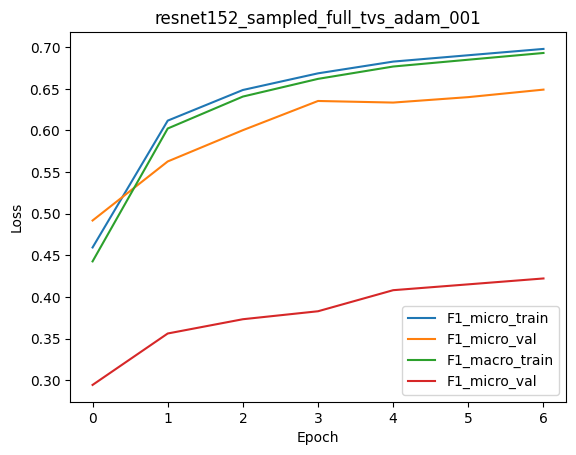

In [42]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(train_f1_micros, label='F1_micro_train')
ax.plot(val_f1_micros, label='F1_micro_val')
ax.plot(train_f1_macros, label='F1_macro_train')
ax.plot(val_f1_macros, label='F1_micro_val')
ax.set_title(model_name)
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()
plt.show()

In [35]:
item = 13
model.eval()
pred = model(val_dataset.__getitem__(item)['images'].unsqueeze(0).to(device)).data.max(1,keepdim=True)[1], 
int(pred[0][0][0]), int(val_dataset.__getitem__(item)['labels'])

(71, 72)

In [27]:
last_epoch = 3
model_name = 'detector_resnet50_augmented'


if last_epoch == None:
    train_losses = []
    val_losses = []
else:
    # Загрузка весов модели
    checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_{model_name}_{last_epoch}.pth'), map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
    #epoch = checkpoint['epoch']
    train_losses = checkpoint['losses_train']
    val_losses = checkpoint['losses_val']

In [403]:
lr_scheduler.state_dict()

{'step_size': 1,
 'gamma': 0.9,
 'base_lrs': [0.001],
 'last_epoch': 30,
 'verbose': False,
 '_step_count': 31,
 '_get_lr_called_within_step': False,
 '_last_lr': [4.239115827521624e-05]}

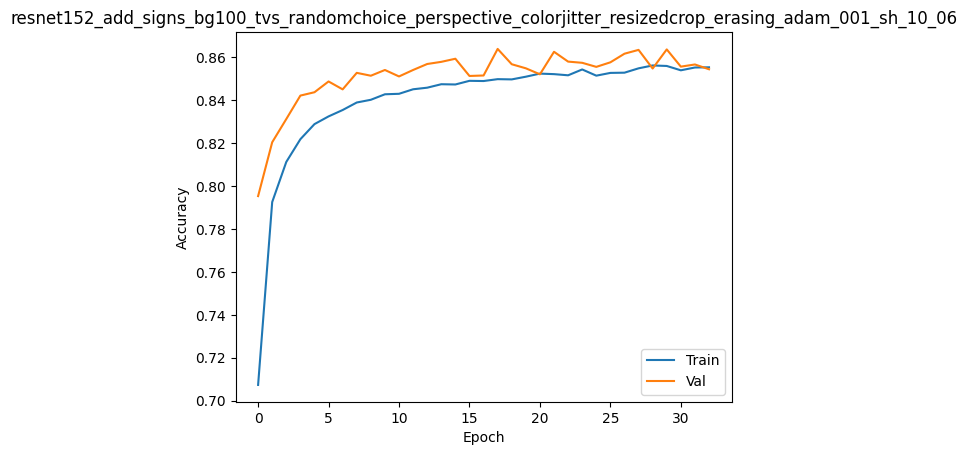

In [129]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(train_accuracies, label='Train')
ax.plot(val_accuracies, label='Val')
ax.set_title('resnet152_add_signs_bg100_tvs_randomchoice_perspective_colorjitter_resizedcrop_erasing_adam_001_sh_10_06')
ax.set(xlabel='Epoch', ylabel='Accuracy')
ax.legend()
plt.show()

In [135]:
val_f1_micros

[0.7953379433415123,
 0.8204327459290653,
 0.8312513941556993,
 0.8421815748382779,
 0.8437430292215035,
 0.8487619897390141,
 0.8450814186928396,
 0.8527771581530226,
 0.8514387686816864,
 0.8541155476243587,
 0.8511041713138524,
 0.8541155476243587,
 0.8569038590229758,
 0.8579076511264778,
 0.8593575730537585,
 0.8513272362257417,
 0.8515503011376311,
 0.8639304037474904,
 0.856792326567031,
 0.8548962748159714,
 0.8521079634173543,
 0.8625920142761543,
 0.8580191835824225,
 0.857461521302699,
 0.8555654695516395,
 0.8576845862145885,
 0.8616997546285968,
 0.863484273923712,
 0.8547847423600268,
 0.8637073388356011,
 0.8556770020075842,
 0.8566807941110863,
 0.8544501449921927]

In [139]:
for i, val_f1_micro in enumerate(val_f1_micros):
    if val_f1_micro == 0.8637073388356011:
        print(i)
        print(val_f1_micro)

29
0.8637073388356011


In [140]:
val_f1_macros[29]

0.6963865226575303

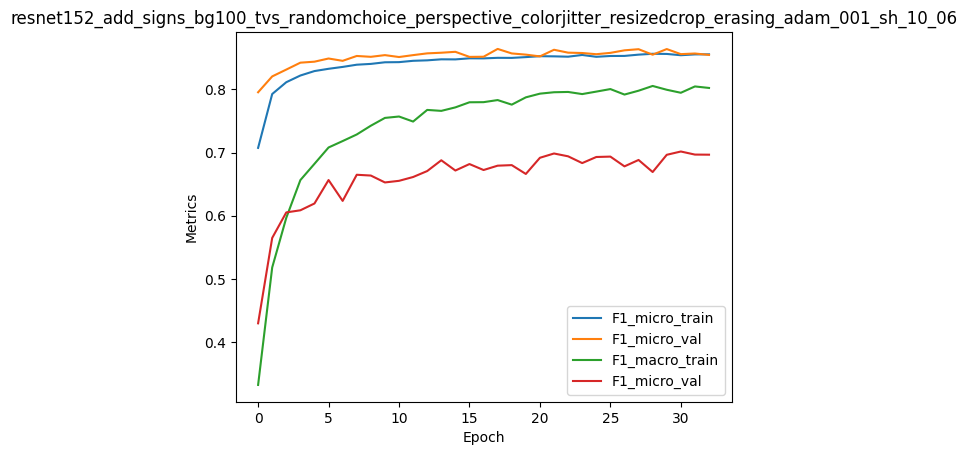

In [130]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(train_f1_micros, label='F1_micro_train')
ax.plot(val_f1_micros, label='F1_micro_val')
ax.plot(train_f1_macros, label='F1_macro_train')
ax.plot(val_f1_macros, label='F1_micro_val')
ax.set_title('resnet152_add_signs_bg100_tvs_randomchoice_perspective_colorjitter_resizedcrop_erasing_adam_001_sh_10_06')
ax.set(xlabel='Epoch', ylabel='Metrics')
ax.legend()
plt.show()

In [ ]:
29
0.8637073388356011
0.6963865226575303

In [173]:
for i, val_f1_micro in enumerate(val_f1_micros):
    if val_f1_micro == max(val_f1_micros):
        print(i)
        print(val_f1_micro)

24
0.8022529556100825


In [175]:
val_f1_micros

[0.6835824224849432,
 0.709346419808164,
 0.7378987285300022,
 0.7308721838054874,
 0.7575284407762659,
 0.7492750390363596,
 0.7782734775819763,
 0.7826232433638188,
 0.7715815302252955,
 0.7798349319652019,
 0.7885344635288868,
 0.7871960740575508,
 0.7786080749498104,
 0.798237787196074,
 0.7755966986393041,
 0.7835155030113763,
 0.7886459959848315,
 0.7960071380771804,
 0.7917689047512825,
 0.7841846977470445,
 0.780838724068704,
 0.7913227749275039,
 0.7960071380771804,
 0.8018068257863038,
 0.8022529556100825]

In [176]:
val_f1_macros

[0.45351877561654186,
 0.4983675255261235,
 0.5303247596628375,
 0.5229882573372168,
 0.5450821317913449,
 0.542786305946213,
 0.5856556046203326,
 0.5710465674896193,
 0.5810164407892296,
 0.5896969266732207,
 0.5941374392402836,
 0.593875712950531,
 0.5798111134581114,
 0.5994347869047867,
 0.6008507588264658,
 0.5779396774141815,
 0.5973864538669285,
 0.6098899615180197,
 0.602880403927328,
 0.6022258266528389,
 0.6017874175184907,
 0.6166859355166453,
 0.5982228818957533,
 0.602251939264438,
 0.6012126664498036]

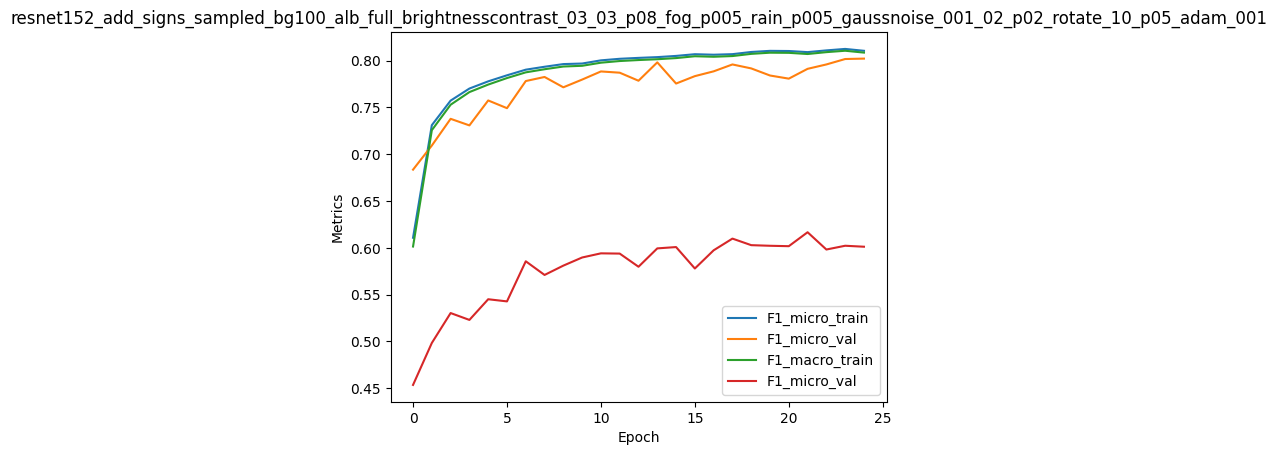

In [177]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(train_f1_micros, label='F1_micro_train')
ax.plot(val_f1_micros, label='F1_micro_val')
ax.plot(train_f1_macros, label='F1_macro_train')
ax.plot(val_f1_macros, label='F1_micro_val')
ax.set_title(model_name)
ax.set(xlabel='Epoch', ylabel='Metrics')
ax.legend()
plt.show()

In [ ]:
24
0.8022529556100825
0.6012126664498036